# Table of Contents
1. [Import Libraries](#Libraries)
2. [Load Kaggle Dataset](#Dataset)
3. [Feature Engineering](#Engineering)
4. [CNN Model Building](#CNN)
5. [Model Evaluation](#Evaluation)
6. [Overall Metrics](#Modelling)

In [1]:
# Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Import Libraries

In [2]:
# Image processing
import os
import PIL
from PIL import Image

# Analysis
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# Model Training
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras import Sequential, Input, Model, layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Flatten, Rescaling, Dropout, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, Rescaling, Resizing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

# Evaluation
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score, auc

# Load Kaggle Dataset and Set Constants

In [3]:
!pip install kaggle

Assigned the input shape and number of classes to variables, and initialised the number of epochs, batch size and learning rate for model training.

In [4]:
# CONSTANTS
DATA_DIR = '/content/dataset'
IMG_HEIGHT = 100
IMG_WIDTH = 100
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_CLASSES = 10

# CONSTANTS
landuse_dict = {
    'highdensitybuildings':0,
    'lowdensitybuildings':1,
    'roads':2,
    'recreational':3,
    'harbor':4,
    'beach':5,
    'forest':6,
    'river':7,
    'runway':8,
    'storagetanks':9,
}
CLASSES = list(landuse_dict.keys())
NUM_CLASSES = len(CLASSES)

In [5]:
if not os.path.exists(DATA_DIR):
  # Create directory to store kaggle credentials
  !mkdir ~/.kaggle
  # Add kaggle.json file in your root folder
  !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
  # Set Permissions
  !chmod 600 ~/.kaggle/kaggle.json
  # Download dataset
  !kaggle datasets download -d racheltanminzhi/landuse
  # Unzip folder
  !unzip /content/landuse.zip -d /content/dataset/
else:
  print('Directory already exists.')

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/recreational/recreational_00502.png  
  inflating: /content/dataset/recreational/recreational_00503.png  
  inflating: /content/dataset/recreational/recreational_00504.png  
  inflating: /content/dataset/recreational/recreational_00505.png  
  inflating: /content/dataset/recreational/recreational_00506.png  
  inflating: /content/dataset/recreational/recreational_00507.png  
  inflating: /content/dataset/recreational/recreational_00508.png  
  inflating: /content/dataset/recreational/recreational_00509.png  
  inflating: /content/dataset/recreational/recreational_00510.png  
  inflating: /content/dataset/recreational/recreational_00511.png  
  inflating: /content/dataset/recreational/recreational_00512.png  
  inflating: /content/dataset/recreational/recreational_00513.png  
  inflating: /content/dataset/recreational/recreational_00514.png  
  inflating: /content/dataset/recreational/recreational_00515.png

In [6]:
def create_ds(directory):
    file_names = []
    y = []
    for root, directories, files in os.walk(directory):
        for file in files:
            y.append(landuse_dict[root.split('/')[-1]])
            file_names.append(os.path.join(root, file))
    X = np.stack([(Image.open(file)).resize((100, 100)) for file in file_names])
    y = np.array(y).reshape(-1, 1)
    return X, y

In [7]:
X, y = create_ds('/content/dataset')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Engineering

No. of records in train data: 7600<br>
No. of records in test data: 1901<br>
Dimensions of original images: 256 x 256<br>
Dimensions of resized images used in training: 100 x 100<br>

In [9]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
print(y_train.shape)
print(y_test.shape)

(7600, 10)
(1901, 10)


Before training the baseline model, we split the current train dataset (using scikit-learn's train_test_split method) further into train and validation datasets. We will use the test sets to assess the model's performance.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Model Building

In [11]:
# Initalise model
baseline_model = Sequential()

# Hidden layers

# Add rescaling layer to normalize pixel values to a specific range (e.g., [0, 1])
baseline_model.add(Rescaling(scale=1./255, input_shape=INPUT_SHAPE))

# Add resizing layer to resize input images to a fixed size
baseline_model.add(Resizing(height=IMG_HEIGHT, width=IMG_WIDTH))

baseline_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',
                     input_shape=INPUT_SHAPE, name='Conv_1'))
baseline_model.add(BatchNormalization(name='BatchNorm_1'))
baseline_model.add(MaxPooling2D((2, 2), name='MaxPool_1'))

baseline_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
baseline_model.add(BatchNormalization(name='BatchNorm_2'))
baseline_model.add(MaxPooling2D((2, 2), name='MaxPool_2'))

# Flatten
baseline_model.add(Flatten(name='Flatten'))

# Fully connected layers
baseline_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', name='FullyConnected_1'))
baseline_model.add(BatchNormalization(name='BatchNorm_7'))

# Output layer
baseline_model.add(Dense(NUM_CLASSES, activation='softmax', name='Output'))

# Summary of model
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 resizing (Resizing)         (None, 100, 100, 3)       0         
                                                                 
 Conv_1 (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 BatchNorm_1 (BatchNormaliz  (None, 100, 100, 64)      256       
 ation)                                                          
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 50, 50, 64)        0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 128)       73856     
                                                        

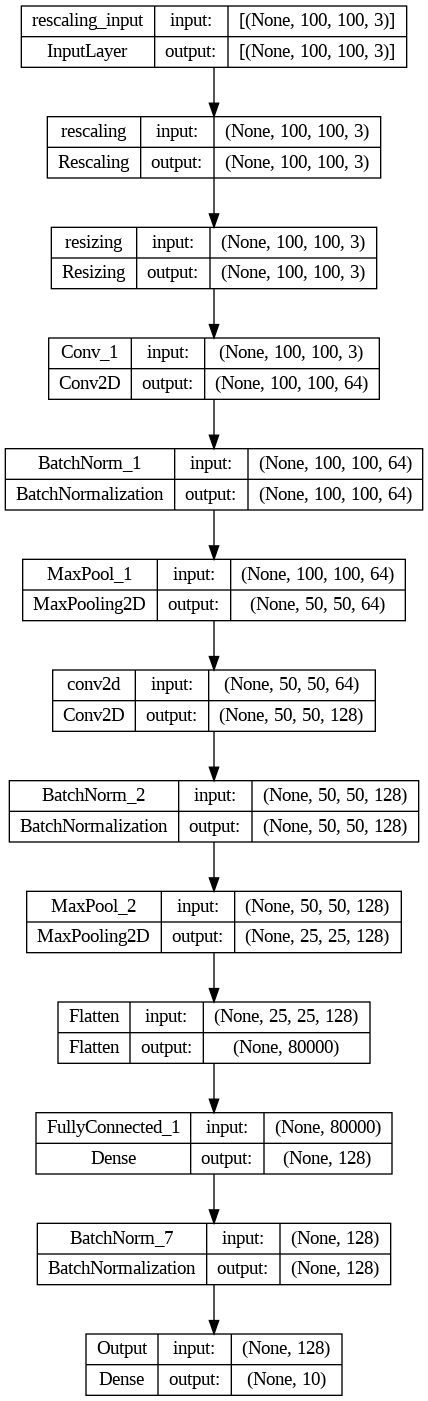

In [12]:
# Plot graphical summary of the baseline model
model_plot = plot_model(baseline_model, to_file='baseline_model.png', show_shapes=True)
display(model_plot)

In [13]:
# Define optimizer
optimizer = Adam(learning_rate=LEARNING_RATE)

# Compile model
baseline_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
baseline_history = baseline_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
95/95 [==============================] - 12s 54ms/step - loss: 1.8255 - accuracy: 0.3887 - val_loss: 9.9103 - val_accuracy: 0.0928
Epoch 2/10
95/95 [==============================] - 5s 48ms/step - loss: 1.0733 - accuracy: 0.6403 - val_loss: 21.3494 - val_accuracy: 0.0770
Epoch 3/10
95/95 [==============================] - 5s 50ms/step - loss: 0.7464 - accuracy: 0.7605 - val_loss: 15.1900 - val_accuracy: 0.1283
Epoch 4/10
95/95 [==============================] - 5s 48ms/step - loss: 0.3278 - accuracy: 0.9128 - val_loss: 5.7262 - val_accuracy: 0.2750
Epoch 5/10
95/95 [==============================] - 5s 48ms/step - loss: 0.1312 - accuracy: 0.9763 - val_loss: 3.0913 - val_accuracy: 0.3513
Epoch 6/10
95/95 [==============================] - 5s 50ms/step - loss: 0.0383 - accuracy: 0.9959 - val_loss: 1.7183 - val_accuracy: 0.5138
Epoch 7/10
95/95 [==============================] - 5s 48ms/step - loss: 0.0163 - accuracy: 0.9988 - val_loss: 1.4349 - val_accuracy: 0.5895
Epoch 8/10

# Model Improvement
The biggest issue with our baseline CNN model was overfitting. In order to improve this, we carried out dropout regularisation, data augmentation and added a resizing layer.

**Build Improved Model**<br>
There are two main issues we aim to resolve in the improved model:
1. Reduce overfitting: We implemented **dropout regularisation and added resizing layers** to reduce overfitting due to over-reliance on a few inputs so that the layer learns to generalise. This forces the model to summarize and compress information from local regions of the input. This helps to prevent overfitting by discouraging the model from learning overly complex or detailed representations that may be specific to the training data but not generalizable to unseen data.
2. Increase the model's accuracy: We also **increased the number of epochs from 10 to 30**. Additionally, we **increased the depth of the model by adding more convolutional layers**. With more convolutional layers, the model is better able to discriminate between the different classes. The additional layers ensure the model learns the discriminative features that distinguish between similar-looking objects or patterns, leading to better classification accuracy.

Additionally, I introduced batch normalisation to the improved model. I kept some parameters constant such as the optimizer and learning rate.

<a id='Augmentation'></a>
## Data Augmentation
We used data augmentation to synthetically create more images by modifying current data to improve model prediction accuracy. With an increase in data, the model is forced to generalise and this helps to reduce overfitting.

 These transformations create variations of the original images, making the model more unchanging when it comes to changes such as orientation. This also introduces variability and more realistic scenarios, helping the model to learn more robust and generalizable features which can be applied to unseen data.

In [15]:
datagen = ImageDataGenerator(
    rotation_range = 5, # Randomly rotate images in the range by 5 degrees
    zoom_range = 0.1, # Randomly zoom image by 10%
    shear_range = 0.3, # Shear angle in counter-clockwise direction in degrees by 30%
    width_shift_range = 0.1, # randomly shift images horizontally by 10%
    height_shift_range = 0.1, # randomly shift images vertically by 10%
)

In [16]:
# Initalise model
model = Sequential()

# Hidden layers

# Add rescaling layer to normalize pixel values to a specific range (e.g., [0, 1])
model.add(Rescaling(scale=1./255, input_shape=INPUT_SHAPE))

# Add resizing layer to resize input images to a fixed size
model.add(Resizing(height=IMG_HEIGHT, width=IMG_WIDTH))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',
                     input_shape=INPUT_SHAPE, name='Conv_1'))
model.add(BatchNormalization(name='BatchNorm_1'))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization(name='BatchNorm_2'))
model.add(MaxPooling2D((2, 2), name='MaxPool_1'))
model.add(Dropout(0.3, name='Dropout_1'))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization(name='BatchNorm_3'))
model.add(MaxPooling2D((2, 2), name='MaxPool_2'))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization(name='BatchNorm_4'))
model.add(MaxPooling2D((2, 2), name='MaxPool_3'))
model.add(Dropout(0.4, name='Dropout_2'))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization(name='BatchNorm_5'))
model.add(MaxPooling2D((2, 2), name='MaxPool_4'))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization(name='BatchNorm_6'))
model.add(MaxPooling2D((2, 2), name='MaxPool_5'))
model.add(Dropout(0.4, name='Dropout_3'))

# Flatten
model.add(Flatten(name='Flatten'))

# Fully connected layers
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', name='FullyConnected_1'))
model.add(BatchNormalization(name='BatchNorm_7'))
model.add(Dropout(0.4, name='Dropout_4'))

# Output layer
model.add(Dense(NUM_CLASSES, activation='softmax', name='Output'))

# Summary of model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 resizing_1 (Resizing)       (None, 100, 100, 3)       0         
                                                                 
 Conv_1 (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 BatchNorm_1 (BatchNormaliz  (None, 100, 100, 64)      256       
 ation)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 BatchNorm_2 (BatchNormaliz  (None, 100, 100, 64)      256       
 ation)                                               

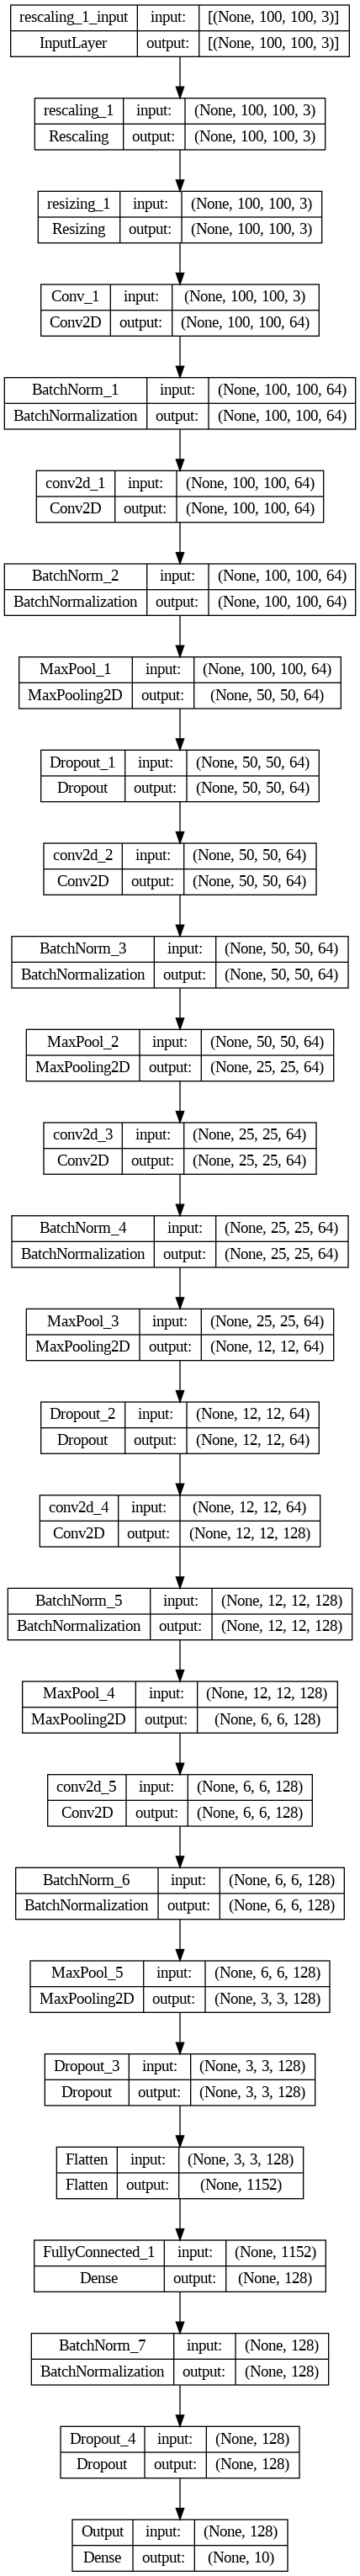

In [17]:
# Plot graphical summary of the improved model
model_plot = plot_model(model, to_file='model.png', show_shapes=True)
display(model_plot)

To prevent overfitting, we also tried different values of patience such as 5, 10 and 15 by stopping the training if the validation loss stops improving. With 30 epochs, we found that we could achieve the best accuracy with this method using patience=10. We also used model checkpoints to save the model consistently.

In [18]:
# Define optimizer
optimizer = Adam(learning_rate=LEARNING_RATE)

# Compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint('checkpoints/', monitor='val_loss'),
             ReduceLROnPlateau(monitor='val_accuracy')]

In [19]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), epochs=30,
                        validation_data = (X_val, y_val), callbacks=callbacks)

Epoch 1/30
95/95 [==============================] - 39s 314ms/step - loss: 2.3967 - accuracy: 0.2661 - val_loss: 4.3803 - val_accuracy: 0.1355 - lr: 0.0010
Epoch 2/30
95/95 [==============================] - 24s 256ms/step - loss: 1.6597 - accuracy: 0.4324 - val_loss: 5.9790 - val_accuracy: 0.1961 - lr: 0.0010
Epoch 3/30
95/95 [==============================] - 24s 254ms/step - loss: 1.3675 - accuracy: 0.5270 - val_loss: 4.7716 - val_accuracy: 0.2671 - lr: 0.0010
Epoch 4/30
95/95 [==============================] - 24s 253ms/step - loss: 1.2111 - accuracy: 0.5771 - val_loss: 2.8678 - val_accuracy: 0.3513 - lr: 0.0010
Epoch 5/30
95/95 [==============================] - 24s 256ms/step - loss: 1.0817 - accuracy: 0.6153 - val_loss: 2.0365 - val_accuracy: 0.4612 - lr: 0.0010
Epoch 6/30
95/95 [==============================] - 24s 251ms/step - loss: 0.9718 - accuracy: 0.6492 - val_loss: 3.1687 - val_accuracy: 0.3697 - lr: 0.0010
Epoch 7/30
95/95 [==============================] - 24s 257ms/st

# Model Evaluation

In [20]:
# List of models
model_names = ['Baseline CNN', 'Improved CNN']
models = [baseline_model, model]
# List of history
model_hist = [baseline_history, history]
# Create a dictionary to map the model to its index
model_dict = {}
for i, model in enumerate(model_names):
  model_dict[model] = i
model_dict

{'Baseline CNN': 0, 'Improved CNN': 1}

For evaluation of the models, we decided to standardise and use accuracy, precision, recall, f1 score and ROC AUC score to better compare their metrics. We also used a confusion matrix to gauge the accuracy visually.

**Accuracy, Precision, Recall, F1 Score, ROC AUC Score**

In [21]:
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

In [22]:
def get_metrics(models):
  metrics_list = []
  pred_list = []
  predproba_list = []
  for model in models:
    # Predict the values from the validation dataset
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis = 1)

    # Get accuracy precision, recall, f1 score, roc-auc score
    acc = model.evaluate(X_test, y_test, verbose=0)
    precision = precision_score(y_true, y_pred_classes, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    rocauc = roc_auc_score(y_true, y_pred, multi_class='ovr')
    metrics_list.append([acc[1]*100, precision, recall, f1, rocauc])
    pred_list.append(y_pred_classes)
    predproba_list.append(y_pred)
  return metrics_list, pred_list, predproba_list

# Create a dataframe of metrics
metrics, predictions, predprobas = get_metrics(models)
df_metrics = pd.DataFrame(metrics)
df_metrics.rename(index={0:'Baseline CNN', 1:'Improved CNN'},
                  columns={0:'Accuracy', 1:'Precision', 2:'Recall', 3:'F1 Score', 4:'ROC AUC'},
                  inplace=True)
df_metrics

Accuracy  Precision    Recall  F1 Score   ROC AUC
Baseline CNN  61.073118   0.600584  0.610731  0.598733  0.909565
Improved CNN  78.327197   0.851934  0.783272  0.785228  0.980548

**Training History**

In [23]:
def plot_traininghist(model, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
    # Title
    fig.suptitle(f'{name}', size=18, fontweight='bold', y=1.05)

    # Accuracy
    sns.lineplot(model.history['accuracy'], ax=axes[0], color='#1338BE', label = 'Train')
    sns.lineplot(model.history['val_accuracy'], ax=axes[0], color='#FF7420', label = 'Validation')

    axes[0].set_title(f'Accuracy per epoch', fontsize=14, fontweight="bold", loc="left", pad=18)
    axes[0].set_xticks(range(0, 11))
    axes[0].legend(loc='lower right')

    # Loss
    sns.lineplot(model.history['loss'], ax=axes[1], color='#7734EA', label = 'Train')
    sns.lineplot(model.history['val_loss'], ax=axes[1], color='#FC123E', label = 'Validation')

    axes[1].set_title(f'Loss per epoch', fontsize=14, fontweight="bold", loc="left", pad=18)
    axes[1].set_xticks(range(0, 31))
    axes[1].legend(loc='upper right')

    sns.despine(top=True, right=True)
    plt.show()

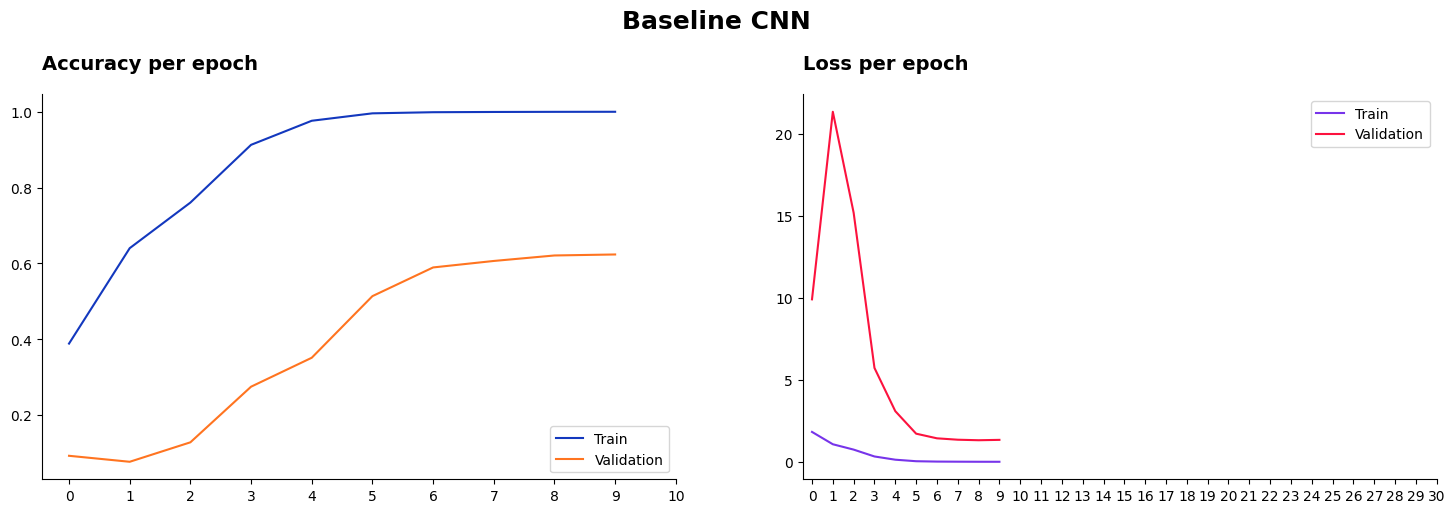

In [24]:
plot_traininghist(model_hist[model_dict['Baseline CNN']], 'Baseline CNN')

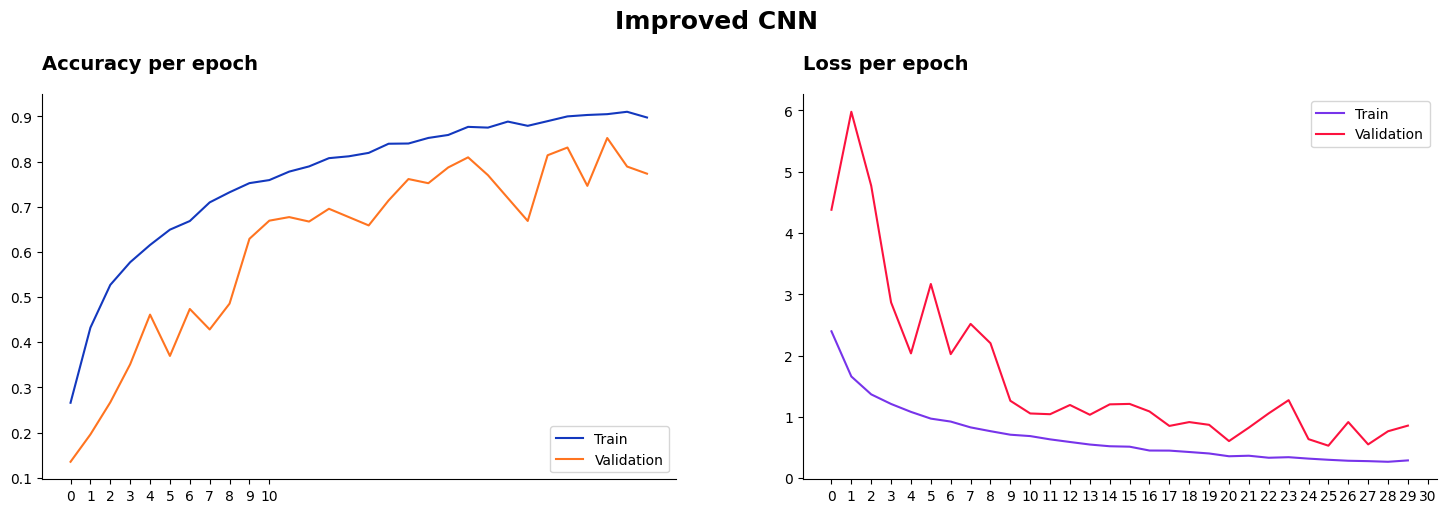

In [25]:
plot_traininghist(model_hist[model_dict['Improved CNN']], 'Improved CNN')

**Confusion Matrix**

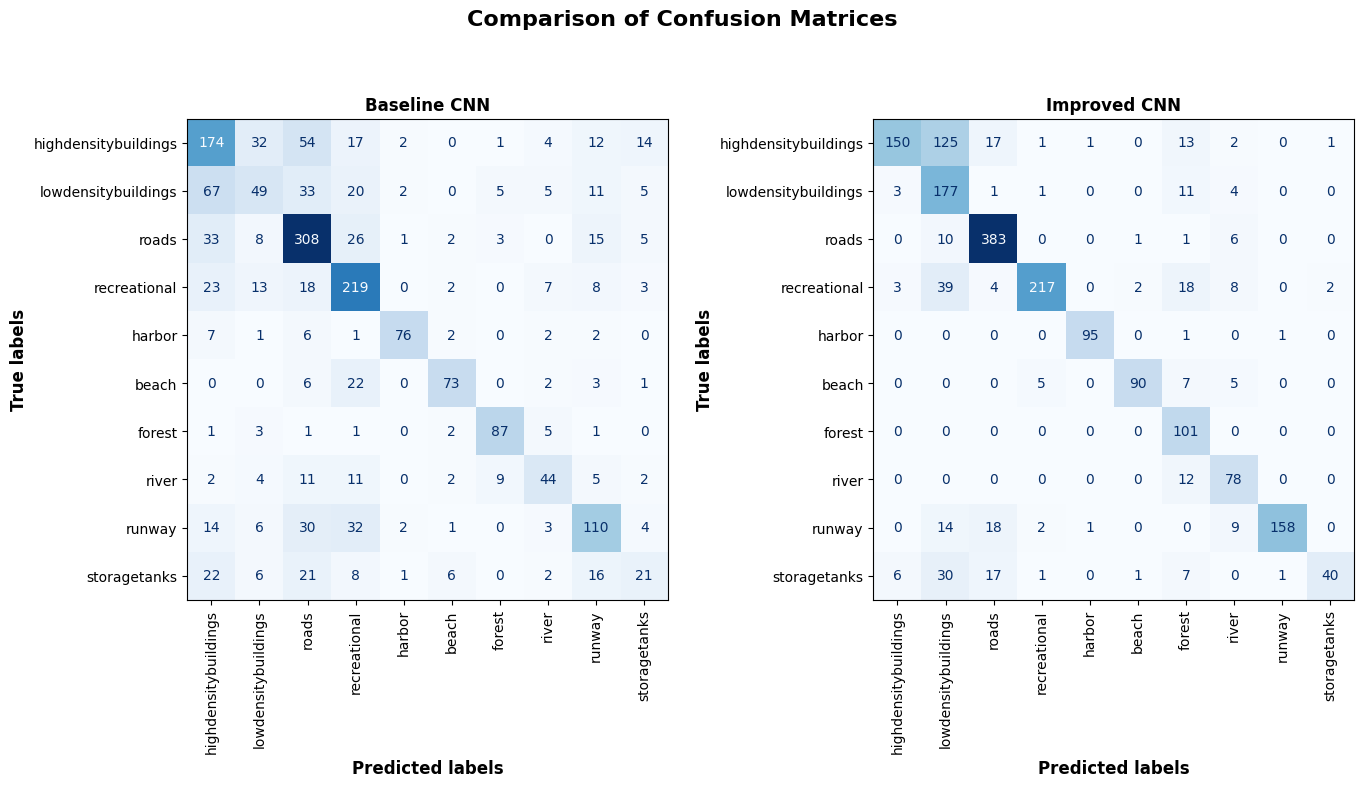

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
fig.suptitle('Comparison of Confusion Matrices', size=16, fontweight='bold')
for name, model, y_pred, ax in zip(model_names, models, predictions, axes.flatten()):
    # Plot confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, cmap='Blues', colorbar=False, display_labels=CLASSES)
    # Set title as the model's name
    ax.set_title(name, size=12, fontweight='bold')
    # Change label and tick labels size
    ax.set_xlabel('Predicted labels', size=12, fontweight='bold')
    ax.set_ylabel('True labels', size=12, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticklabels(CLASSES, rotation=90)
fig.tight_layout(pad = 2.0)
plt.show()

**AUC-ROC Curve**

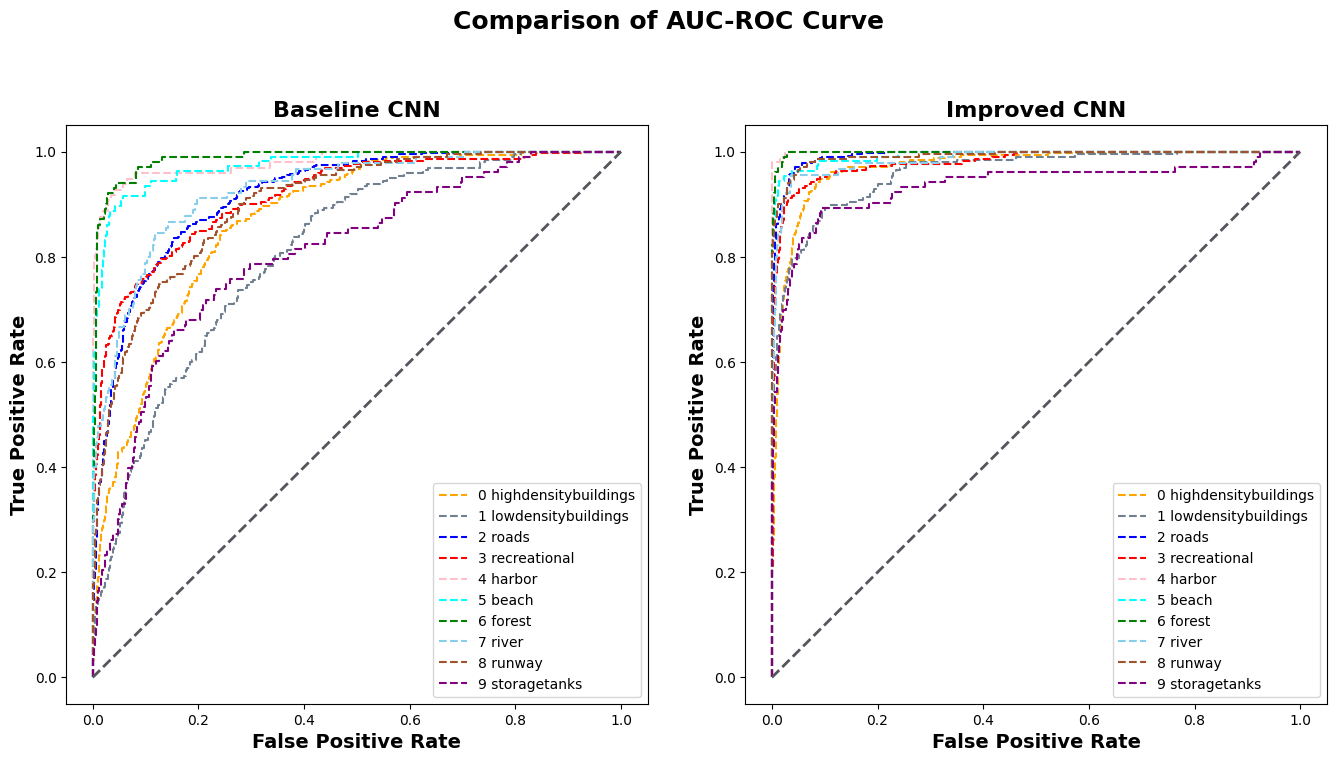

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
fig.suptitle('Comparison of AUC-ROC Curve', size=18, fontweight='bold')
auc_list = []
for name, model, y_prob, ax in zip(model_names, models, predprobas, axes.flatten()):
    auc_score = {}
    fpr = {}
    tpr = {}
    thresh ={}

    # compute roc by passing in the actual and predicted values
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], thresh[i] = roc_curve(y_true, y_prob[:,i], pos_label=i)
        auc_score[i] = auc(fpr[i], tpr[i])

    auc_list.append(auc_score)

    # plotting
    ax.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='0 highdensitybuildings')
    ax.plot(fpr[1], tpr[1], linestyle='--',color='slategrey', label='1 lowdensitybuildings')
    ax.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='2 roads')
    ax.plot(fpr[3], tpr[3], linestyle='--',color='red', label='3 recreational')
    ax.plot(fpr[4], tpr[4], linestyle='--',color='pink', label='4 harbor')
    ax.plot(fpr[5], tpr[5], linestyle='--',color='cyan', label='5 beach')
    ax.plot(fpr[6], tpr[6], linestyle='--',color='green', label='6 forest')
    ax.plot(fpr[7], tpr[7], linestyle='--',color='skyblue', label='7 river')
    ax.plot(fpr[8], tpr[8], linestyle='--',color='sienna', label='8 runway')
    ax.plot(fpr[9], tpr[9], linestyle='--',color='purple', label='9 storagetanks')

    ax.plot([0, 1], [0, 1], color='#56545C', lw=2, linestyle='--')
    # Set title as the model's name
    ax.set_title(name, size = 16, fontweight='bold')
    # Set axes labels
    ax.set_xlabel('False Positive Rate', size = 14, fontweight='bold')
    ax.set_ylabel('True Positive Rate', size = 14, fontweight='bold')
    # Set legend
    ax.legend(loc="lower right")

fig.tight_layout(pad = 3.0)
plt.show()

In [28]:
df_auc = pd.DataFrame(auc_list, index=model_names)
df_auc = df_auc.set_axis(CLASSES, axis=1)
df_auc.reset_index(inplace=True)
df_auc.rename(columns={'index': 'models'}, inplace=True)
df_auc = df_auc.melt('models', var_name='label', value_name='auc')
df_auc

models                 label       auc
0   Baseline CNN  highdensitybuildings  0.870505
1   Improved CNN  highdensitybuildings  0.971878
2   Baseline CNN   lowdensitybuildings  0.810532
3   Improved CNN   lowdensitybuildings  0.959802
4   Baseline CNN                 roads  0.919225
5   Improved CNN                 roads  0.992973
6   Baseline CNN          recreational  0.916340
7   Improved CNN          recreational  0.979524
8   Baseline CNN                harbor  0.980256
9   Improved CNN                harbor  0.999583
10  Baseline CNN                 beach  0.974599
11  Improved CNN                 beach  0.992910
12  Baseline CNN                forest  0.987272
13  Improved CNN                forest  0.998564
14  Baseline CNN                 river  0.927321
15  Improved CNN                 river  0.984698
16  Baseline CNN                runway  0.901558
17  Improved CNN                runway  0.991573
18  Baseline CNN          storagetanks  0.808039
19  Improved CNN          storagetanks  0.933972

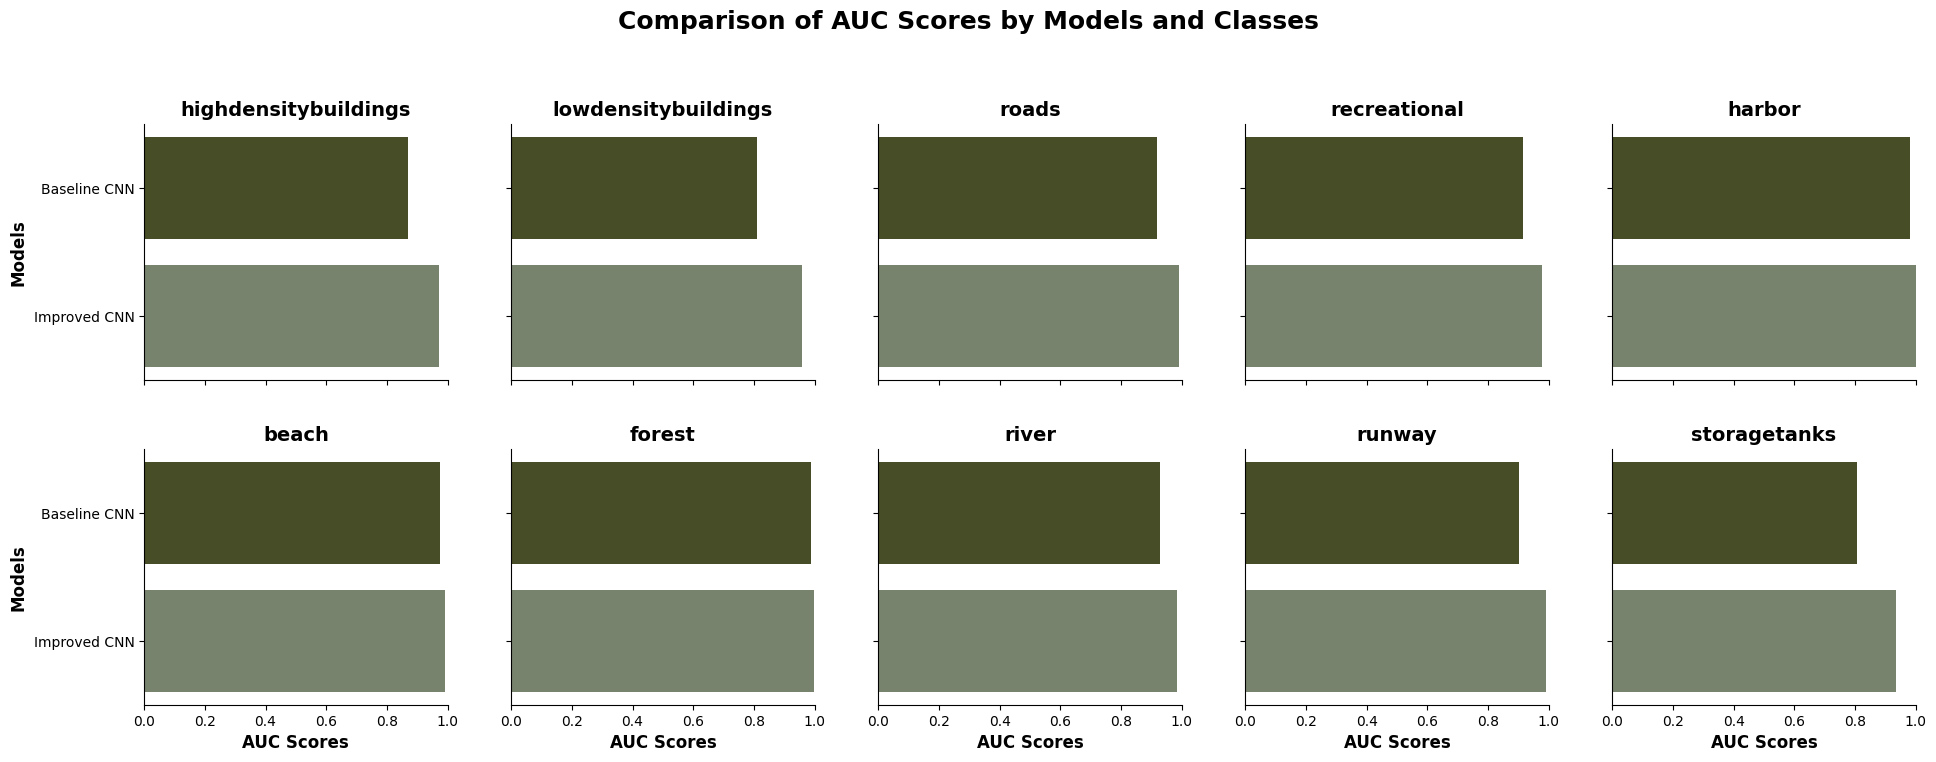

In [29]:
g = sns.catplot(data=df_auc, x='auc', y='models', col='label', col_wrap=5, kind='bar', hue='models', palette=['#4B5320', '#78866B'], height=4, legend=False)
g.fig.subplots_adjust(top=0.9, hspace = 0.8)
g.fig.suptitle('Comparison of AUC Scores by Models and Classes', size=18, fontweight='bold')
g.set_axis_labels('AUC Scores', 'Models', size=12, fontweight='bold')
g.set_titles('{col_name}', size=14, fontweight='bold')
g.set(xlim=(0, 1))
g.fig.tight_layout(pad = 3.0)
plt.show()

**Model Confidence and Incorrectly Predicted Class**

In [30]:
# Confidence Level
def conf_levels(predprob, predclass):
    # Set a condition to filter for records that were incorrectly predicted
    condition = (predclass != y_true)

    # Get the highest percentage out of all classes
    confidence = np.max(predprob, axis=1)

    # Filter for records that were incorrectly predicted
    incorrect_confidence = confidence[condition]

    # Store values in a list
    mean_confidence = []
    for num in range(0, 10):
        # Calculate average confidence of model in its predictions
        mean_val = np.mean(confidence[y_true == num])
        mean_confidence.append(f'{mean_val*100:.2f}%')

    # Create a dataframe to display values
    class_names = pd.Series(CLASSES)
    mean_confidence = pd.Series(mean_confidence)
    df_confidence = pd.concat([class_names, mean_confidence], axis=1)
    df_confidence.columns = ['Class', 'Confidence Level']
    df_confidence.sort_values('Confidence Level', key=lambda x: x.str.rstrip('%').astype(float), ascending=False, inplace=True)

    ## For plotting incorrectly predicted image samples
    # Actual class of records for incorrectly classified samples
    true_class = y_true[condition]
    # Incorrectly predicted class
    incorrect_pred = predclass[condition]

    # Filter for incorrect val images
    X_test_incorrect = X_test[condition]
    X_test_incorrect = X_test_incorrect.reshape(incorrect_pred.shape[0], 100, 100, 3)

    # Define number of samples
    num_samples = 30
    # Choose samples randomly
    random_idxpred = np.random.choice(incorrect_pred.shape[0], num_samples, replace=False)

    # Plot samples
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    fig.suptitle('Predicted vs Actual Class Labels', size = 20,  y = 1.05)

    for idx, ax in zip(random_idxpred, axes.flatten()):
      ax.imshow(X_test_incorrect[idx], cmap='gray')
      ax.set_title(f'Actual: {CLASSES[true_class[idx]]}\nPredicted: {CLASSES[incorrect_pred[idx]]}\
        \n({incorrect_confidence[idx]*100:.2f}%)', color='red')
      ax.axis('off')
    plt.tight_layout()
    plt.show()

    return df_confidence

**Baseline CNN**

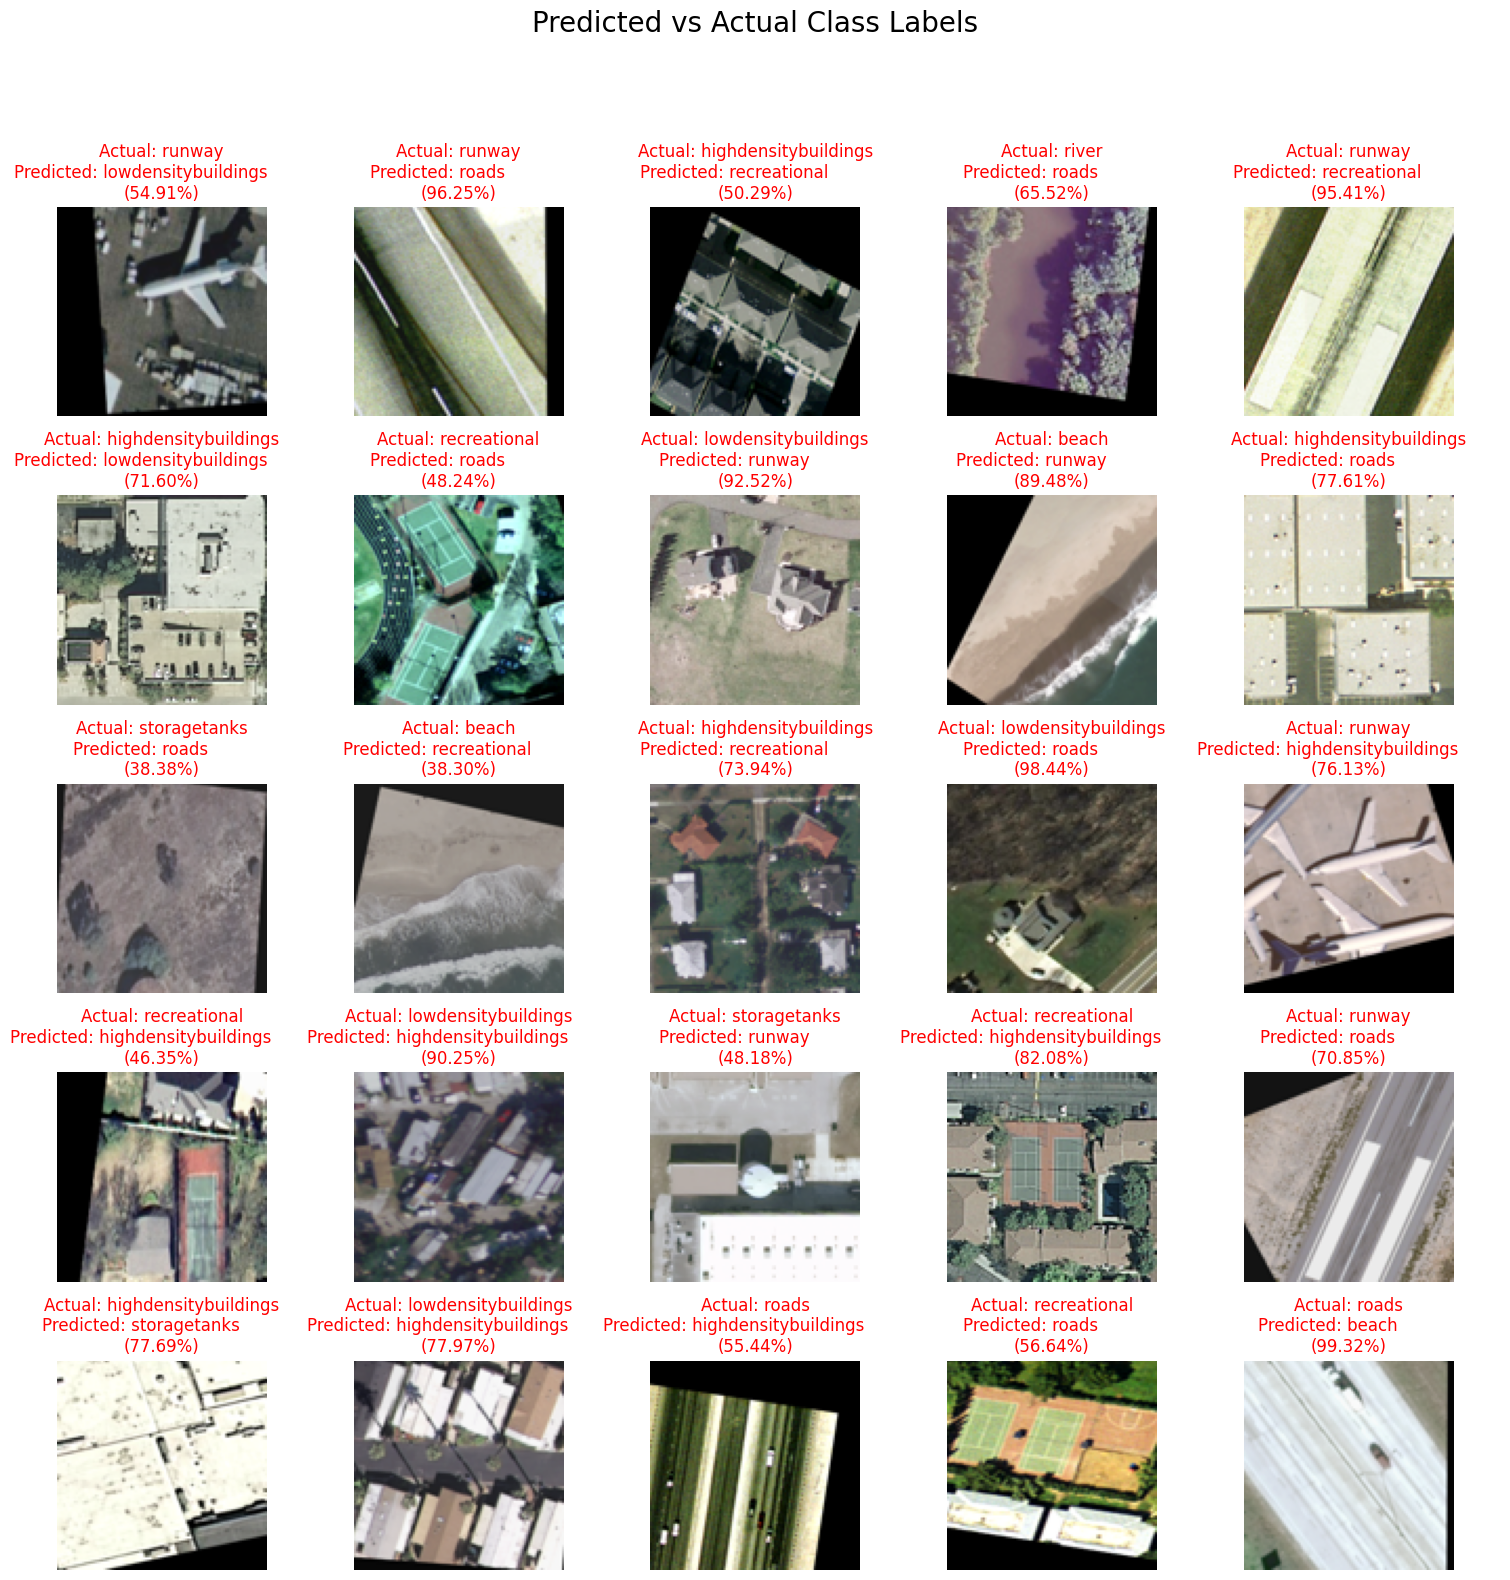

In [31]:
df_confidence_baseline = conf_levels(predprobas[model_dict['Baseline CNN']], predictions[model_dict['Baseline CNN']])

In [32]:
df_confidence_baseline

Class Confidence Level
6                forest           85.85%
5                 beach           85.29%
3          recreational           84.50%
4                harbor           83.75%
2                 roads           81.75%
7                 river           76.30%
8                runway           76.00%
0  highdensitybuildings           75.19%
1   lowdensitybuildings           74.66%
9          storagetanks           69.05%

**Improved CNN**

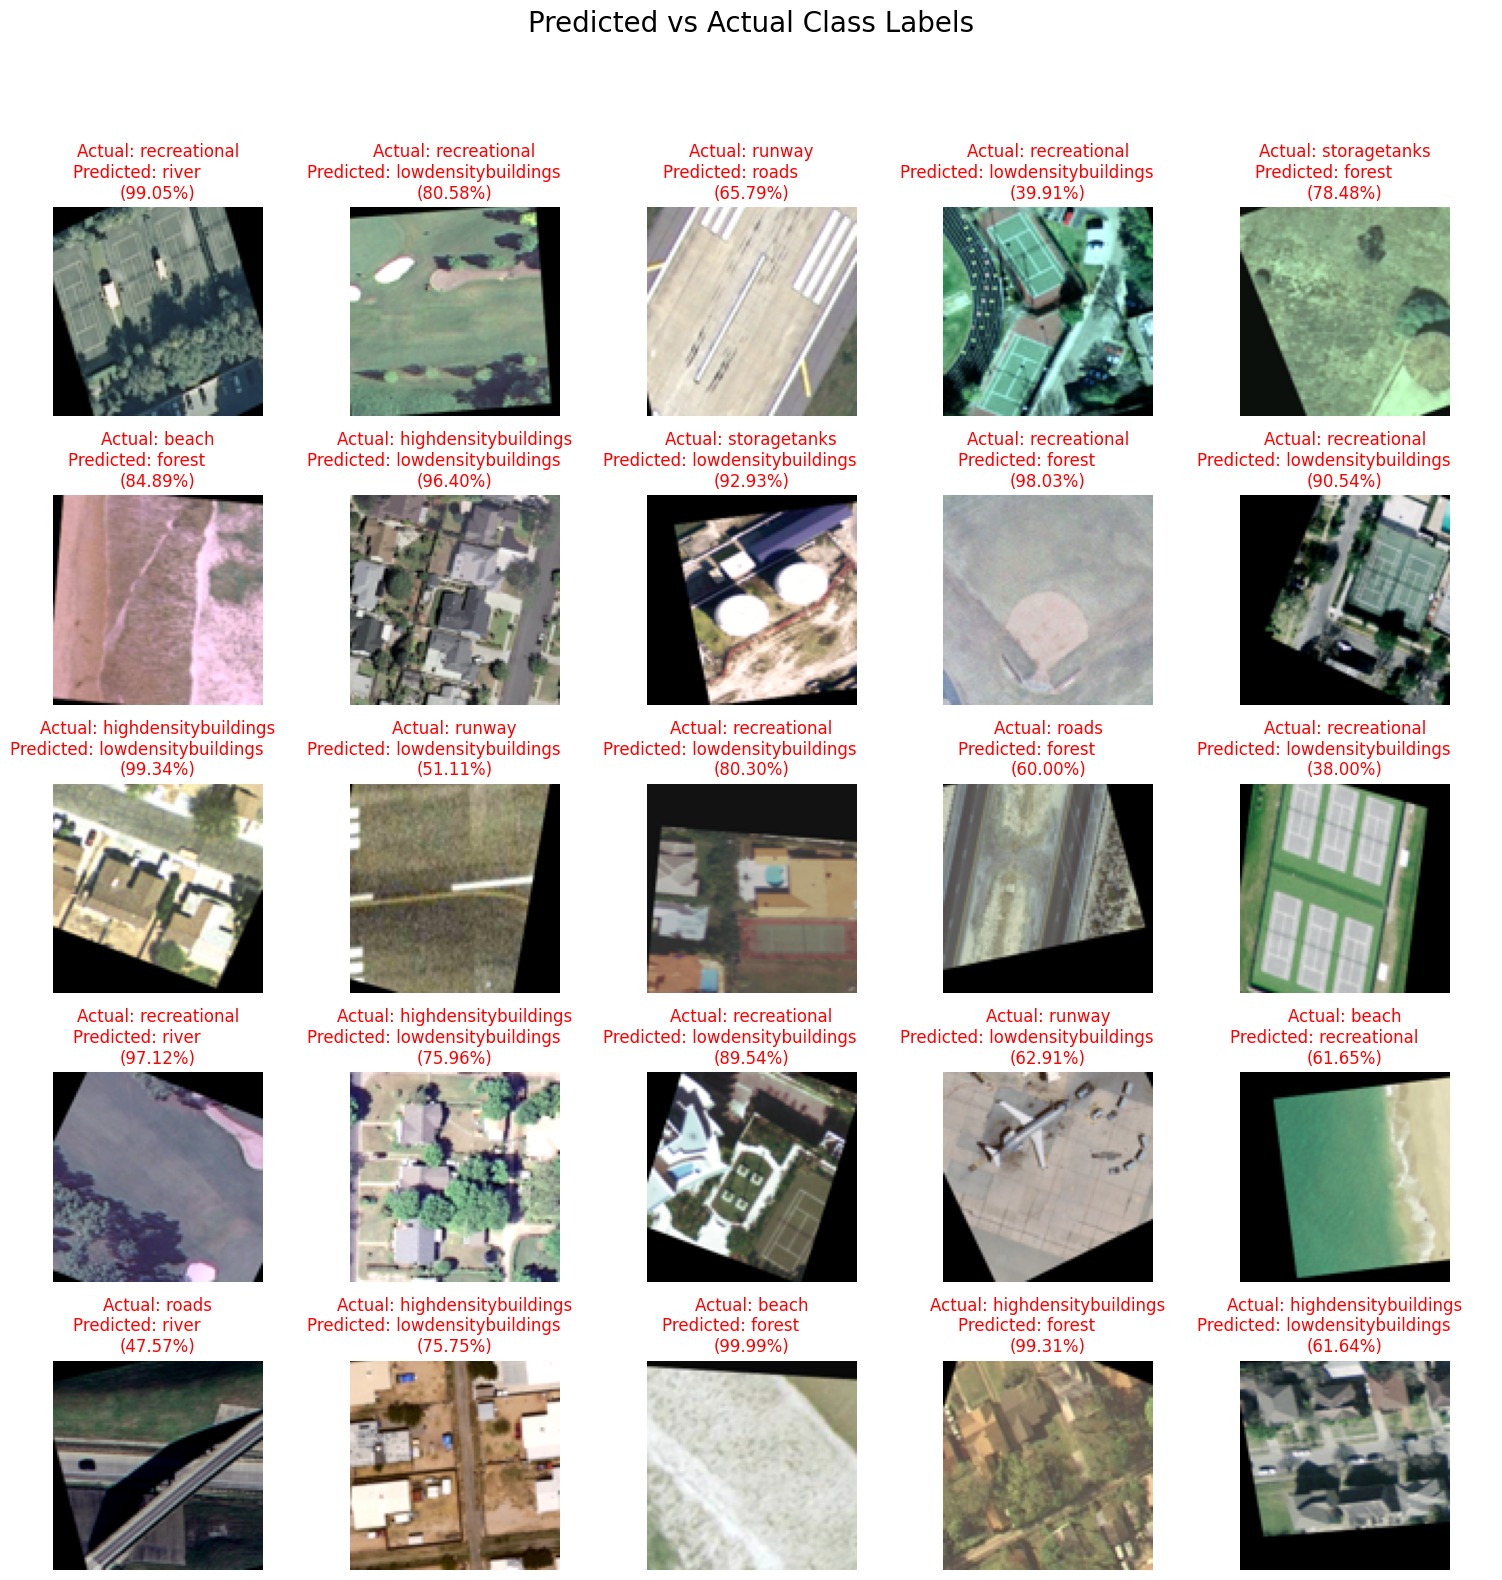

In [33]:
df_confidence_improved = conf_levels(predprobas[model_dict['Improved CNN']], predictions[model_dict['Improved CNN']])

In [34]:
df_confidence_improved

Class Confidence Level
4                harbor           99.72%
6                forest           99.44%
2                 roads           95.85%
1   lowdensitybuildings           94.57%
7                 river           91.89%
8                runway           89.72%
5                 beach           88.67%
3          recreational           87.25%
0  highdensitybuildings           80.77%
9          storagetanks           79.63%

**Save models**

In [35]:
baseline_model.save('./landuse_cnn_baseline.keras')
model.save('./landuse_cnn.keras')